In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd



# autoencoder
class Autoencoder(nn.Module):
  def __init__(self, input_dim, latent_dim):
      super().__init__()
      self.encoder = nn.Sequential(
           nn.Linear(input_dim, 256),
          nn.ReLU(),
          nn.Linear(256, 128),
          nn.ReLU(),
          nn.Linear(128, latent_dim)
        )
      self.decoder = nn.Sequential(
          nn.Linear(latent_dim, 128),
          nn.ReLU(),
          nn.Linear(128, 256),
          nn.ReLU(),
          nn.Linear(256, input_dim)
        )
      self.centers = nn.Parameter(torch.randn(2, latent_dim))

  def forward(self, x):
      encoded = self.encoder(x)
      decoded = self.decoder(encoded)
      return encoded, decoded

  def get_center_loss(self, encoded, target):
      batch_size = encoded.size(0)
      target = target.reshape(-1, 1) #   view
      centers_batch = self.centers.gather(0, target.to(torch.int64).repeat(1, encoded.size(1)))
      center_loss = (encoded - centers_batch).pow(2).sum() / batch_size
      return center_loss



# imbalanced에 data level로 해결하는 모델
class DDHS:
  #데이터를 KDE로 가우시안 분포를 이용하여 중간 %를 추출하는 함수
  # start, last에 퍼센트를 입력

  def extract_middle_percent(self,data, start, last):
    scaler = StandardScaler()
    data_scaled = scaler.fit_transform(data)

    # kde가 큰 데이터셋에서 오래 걸려서서 percentile로 간소화
    if len(data_scaled) > 10000 :
      threshold_low, threshold_high = np.percentile(data_scaled, [start, last])
      mask = np.logical_and(data_scaled >= threshold_low, data_scaled <= threshold_high)
      mask = [True if i.sum() > len(i)/2 else False for i in mask]
    else:
      kde = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(data_scaled)
      log_prob = kde.score_samples(data_scaled)
      prob = np.exp(log_prob)
      threshold_low, threshold_high = np.percentile(prob, [start, last])
      mask = np.logical_and(prob >= threshold_low, prob <= threshold_high) #######

    data_middle = data[mask]

    if len(data_middle) > 0 :
      return data_middle
    else:
      print("No middle 50% found, returning original data")
      return np.array([])

  #  각 feature 안의 값을 복원추출하는 함수

  def reconstruct_features(self,data):
    mean = data.mean(axis=0)
    std = data.std(axis=0)
    reconstructed = np.random.randn(*data.shape) * std + mean
    return reconstructed

  # synthetic sample을 생성하는 함수
  # 라벨과과 데이터를 하나의 데이터프레임으로 출력
  # small class / large class의 비율 = ratio


  def generate_synthetic_sample(self,X,Y, ratio=1):

    data = pd.concat([X,Y],axis=1)

    # small class
    data_A = data[data[Y.columns[0]]== Y.value_counts().idxmin()[0]  ].loc[:, data.columns != Y.columns[0]].astype(float).values

    # large class
    data_B = data[data[Y.columns[0]]== Y.value_counts().idxmax()[0] ].loc[:, data.columns != Y.columns[0]].astype(float).values

    # autoencoder를 사용하여 잠재 변수를 추출
    with torch.no_grad():
        encoded_A, _ = self.model(torch.tensor(data_A).float())
        encoded_B, _ = self.model(torch.tensor(data_B).float())

    # Majority : 입력받은 퍼센트 보다 Density가 큰 샘플을 Keep→ 입력받은 퍼센트 샘플을 Classifier 의 Train 데이터로 활용
    # Minority : 입력받은 퍼센트 을 사용해서 더 높은 기준을 설정 → 입력받은 퍼센트 샘플을 Classifier 의 Train 데이터로 활용 → 25% 샘플을 Subsequence 생성 과정의 샘플로 활용

    encoded_A_middle = self.extract_middle_percent(encoded_A.cpu().numpy(),50 - self.small_percent/2 , 50+ self.small_percent/2)
    encoded_B_middle = self.extract_middle_percent(encoded_B.cpu().numpy(),50 -self.large_percent/2, 50 + self.large_percent/2)

    # 중간 25%의 잠재 변수로부터 feature를 복원추출
    reconstructed_features = self.reconstruct_features(self.extract_middle_percent(encoded_A.cpu().numpy(),37.5, 62.5))
    # 임의의 위치에 synthetic sample 생성
    center_A = np.mean(encoded_A.cpu().numpy(), axis=0, dtype=np.float64, out=None)

    center_B = np.mean(encoded_B.numpy(), axis=0, dtype=np.float64, out=None)

    radius_A = np.max(np.linalg.norm(encoded_A.cpu().numpy() - center_A, axis=1))

    synthetic_sample = pd.DataFrame(reconstructed_features) # 최종 합치기

   # 합성된 개수 / 원래 클래스 개수
    while len(synthetic_sample)/len(data_A) >= ratio :
        z = np.random.randn(latent_dim)
        print(z)
        if np.linalg.norm(z - center_A) < np.linalg.norm(z - center_B) and np.linalg.norm(z - center_A) < radius_A:
            synthetic_sample.append(z) #, ignore_index=True)
            print('들어가는',z)
    # 최종 출력할 데이터
    encoded_B_middle = pd.DataFrame(encoded_B_middle)
    encoded_B_middle['label'] = Y.value_counts().idxmax()[0]

    encoded_A_middle = pd.DataFrame(encoded_A_middle)
    encoded_A_middle['label'] = Y.value_counts().idxmin()[0]

    synthetic_sample['label'] = Y.value_counts().idxmin()[0]

    ouput = pd.concat([encoded_B_middle,encoded_A_middle,synthetic_sample ] )

    x_ = ouput.loc[:, ouput.columns != 'label']
    x_.columns = X.columns
    y_ = ouput['label']
    y_.columns = Y.columns

    return x_ , y_

  def fit(self,X,Y,large_percent = 50 , small_percent = 75 ,lr = 1e-3 ,num_epochs = 50, ratio = 1):
    self.ratio = ratio
    self.large_percent = large_percent
    self.small_percent = small_percent
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    input_dim = len(X.columns) # 데이터의 차원
    latent_dim = len(X.columns) # 잠재 변수의 차원
    #ratio =  합성된 데이터 수/small class  비율
    #large_percent : large class의 추출 비율
    #small_percent : small class의 추출 비율
    #lr = 1e-3 # 학습률
    #num_epochs = 50 # 학습 에폭 수

    self.model = Autoencoder(input_dim, latent_dim).to(device)
    optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)


    for epoch in range(num_epochs):
      x = torch.tensor(X.to_numpy()).float()#.to(device)
      y = torch.tensor(Y[Y.columns[0]].to_numpy()).float().to(device)

      encoded, decoded = self.model(x)
      reconstruction_loss = F.mse_loss(decoded, x)
      center_loss = self.model.get_center_loss(encoded, y)

      loss = reconstruction_loss + center_loss
      cross_entropy_loss = F.cross_entropy(decoded, y.long()) # y를 long 형으로 요구
      loss += cross_entropy_loss

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()


    synthetic_X, synthetic_Y = self.generate_synthetic_sample(X,Y, self.ratio)
    return synthetic_X, synthetic_Y


  def __init__(self):
    self.result = 0

In [ ]:
magic = pd.read_csv('/content/drive/MyDrive/DDHS/magic04.data')

In [ ]:
def pre(x):
  if x =='g':
    return 1
  else:
    return 0

magic['g']=magic['g'].apply(pre)

In [ ]:
from sklearn.model_selection import train_test_split
ddhs = DDHS()

X,y = ddhs.fit(magic.drop('g',axis=1), magic[['g']],50,75,1e-3,100,1)

In [ ]:
X

,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.011,-8.2027,40.092,81.8828
0,-2.126616,-3.279010,-0.788575,-2.564798,-1.652275,-3.532989,5.460667,1.986584,-3.821077,-3.751740
1,-2.249990,-3.141465,-1.840755,-2.492709,-2.962392,-3.795170,6.205806,2.427534,-3.320864,-3.134260
2,-2.611440,-3.845695,-0.686447,-2.783178,-2.246647,-3.905867,6.283360,2.377675,-4.422243,-3.899765
3,-2.397850,-3.067268,-0.164693,-2.338786,-1.721694,-1.337267,3.736513,1.460961,-2.933118,-3.537860
4,-1.956427,-3.616510,-0.910244,-2.191979,-2.460628,-2.015971,5.782335,2.340167,-3.606979,-5.088989
...,...,...,...,...,...,...,...,...,...,...
1668,-3.380819,-2.943280,-0.758749,-1.880999,-0.820313,-8.155615,4.367141,2.627359,-4.541910,-3.040910
1669,-3.223705,-4.317925,-2.911972,0.028227,-2.689125,2.968080,8.975087,1.889019,-0.194757,-1.951011
1670,-2.203607,-1.861672,-1.259977,-4.804815,-4.232499,1.752281,6.615984,0.540684,-1.570728,-3.862559
1671,-2.214821,-1.923862,-1.849162,-4.706887,-0.581042,-1.048442,4.905680,1.391297,-0.952856,-3.232253


In [ ]:
for i in X:
  print(i)

28.7967
16.0021
2.6449
0.3918
0.1982
27.7004
22.011
-8.2027
40.092
81.8828


In [ ]:
X['28.7967'].unique_values

AttributeError: ignored

In [ ]:
a=pd.DataFrame([ 0 for i in range(len(X))]+ [ 1 for i in range(len(X))])
a

,0
0,0
1,0
2,0
3,0
4,0
...,...
22831,1
22832,1
22833,1
22834,1


In [ ]:
a[0]

0        0
1        0
2        0
3        0
4        0
        ..
11413    0
11414    0
11415    0
11416    0
11417    0
Name: 0, Length: 11418, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X,
                                                  y,
                                                  test_size=0.3,
                                                  shuffle=True,
                                                  stratify=y,
                                                  random_state=1004)

NameError: ignored

In [ ]:
# 각 모델 초기화
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()
lgbm_model = LGBMClassifier()
catboost_model = CatBoostClassifier()

# 앙상블에 사용할 모델 리스트
models = [rf_model, xgb_model, lgbm_model, catboost_model]

# 앙상블 예측 결과를 저장할 리스트
ensemble_preds = []

# 각 모델에 대해 학습 및 예측
for model in models:
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_test)
    ensemble_preds.append(preds)

# 앙상블 결과를 투표를 통해 결합
ensemble_results = []
for i in range(len(X_test)):
    votes = [ensemble_preds[j][i] for j in range(len(models))]
    ensemble_results.append(max(set(votes), key=votes.count))

# 앙상블 결과 평가
ensemble_f1_score = f1_score(y_test, ensemble_results)
print(f"앙상블 F1 스코어: {ensemble_f1_score}")

In [ ]:
import lightgbm as lgb

lgb_clf = lgb.LGBMClassifier(num_leaves=31, objective='binary')
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_val)

NameError: ignored

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      1505
           1       0.86      0.94      0.90      1538

    accuracy                           0.90      3043
   macro avg       0.90      0.90      0.90      3043
weighted avg       0.90      0.90      0.90      3043



In [ ]:
X,y = magic.drop('g',axis=1), magic[['g']]
X_train, X_val, y_train, y_val = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    stratify=y,
                                                    random_state=1004)
lgb_clf = lgb.LGBMClassifier(num_leaves=31, objective='binary')
lgb_clf.fit(X_train, y_train)
y_pred = lgb_clf.predict(X_val)
print(classification_report(y_val, y_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


              precision    recall  f1-score   support

           0       0.88      0.76      0.82      2007
           1       0.88      0.94      0.91      3699

    accuracy                           0.88      5706
   macro avg       0.88      0.85      0.86      5706
weighted avg       0.88      0.88      0.88      5706



<ipython-input-10-c0c23af1ef80>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(magic[magic['g']==1]['28.7967'], kde=True, rug=True)
<ipython-input-10-c0c23af1ef80>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(magic[magic['g']==0]['28.7967'], kde=True, rug=True)


<Axes: xlabel='28.7967', ylabel='Density'>

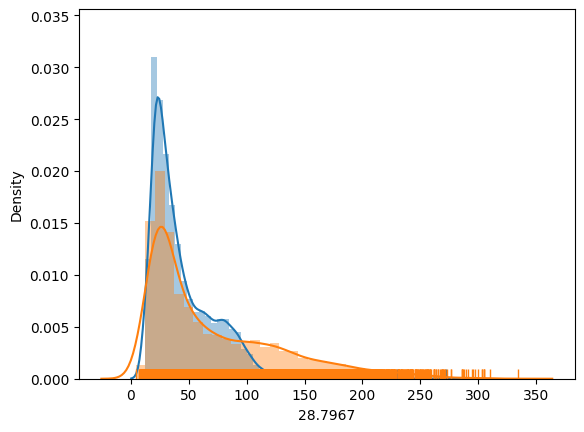

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(magic[magic['g']==1]['28.7967'], kde=True, rug=True)
sns.distplot(magic[magic['g']==0]['28.7967'], kde=True, rug=True)


In [ ]:
y.value_counts()

g
1    12331
0     6688
dtype: int64

In [ ]:
# 언더샘플링 수행
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

# 각 모델 초기화
rf_model = RandomForestClassifier()
xgb_model = XGBClassifier()
lgbm_model = LGBMClassifier()
catboost_model = CatBoostClassifier()

# 앙상블에 사용할 모델 리스트
models = [rf_model, xgb_model, lgbm_model, catboost_model]

# 앙상블 예측 결과를 저장할 리스트
ensemble_preds = []

# 각 모델에 대해 학습 및 예측
for model in models:
    model.fit(X_train_res, y_train_res)
    preds = model.predict(X_test)
    ensemble_preds.append(preds)

# 앙상블 결과를 투표를 통해 결합
ensemble_results = []
for i in range(len(X_test)):
    votes = [ensemble_preds[j][i] for j in range(len(models))]
    ensemble_results.append(max(set(votes), key=votes.count))

# 앙상블 결과 평가
ensemble_f1_score = f1_score(y_test, ensemble_results)
print(f"앙상블 F1 스코어: {ensemble_f1_score}")

NameError: ignored